Import libraries

In [1]:
import os
import time

import torch
import numpy as np

import torch.optim as optim
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from utils import config
from utils.dataset import GraphDataset, GraphData, get_sequential_edge_index
from vectornet.vectornet import VectornetGNN

import matplotlib.pyplot as plt
from utils.data_utils import draw_trajectory, create_ego_raster, create_agents_raster, create_map_raster, decoding_features, increment_to_trajectories

Use training set to test the output, as well as the plot function

In [2]:
# Set seed
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)

# Get validation set
validate_data = GraphDataset(config.TRAIN_PATH)

# Load validation data
validate_loader = DataLoader(
    validate_data,
    batch_size=1
)

# Create predictor
device = device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)

model = VectornetGNN(
    in_channels=config.IN_CHANNELS,
    out_channels=config.OUT_CHANNELS,
).to(device)

model.load_state_dict(
    torch.load(config.WEIGHT_PATH + '/model_epoch_050.pth')
)

<All keys matched successfully>

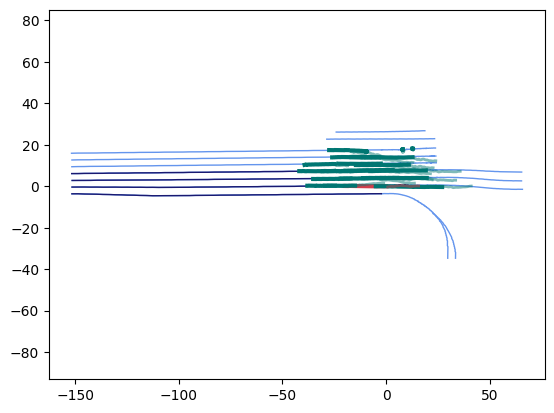

In [8]:
# 确保结果目录存在
if not os.path.exists('./result/'):
    os.makedirs('./result/')

model.eval()
with torch.no_grad():
    for i, data in enumerate(validate_loader):
        data = data.to(device)
        observations = data.x
        model_out = model(data)
        
        ego_past, agent_past_list, \
        lane_list, crosswalk_list, \
        route_lane_list, \
        agent_current_pose_list = decoding_features(observations)        
        predicted_path_list = increment_to_trajectories(model_out.cpu(), agent_current_pose_list)
        
        ground_truth_increment = data.y.cpu()
        ground_truth_increment.view(config.NUM_AGENTS + 1, config.NUM_FUTURE_POSES * 2)
        ground_truth_list = increment_to_trajectories(ground_truth_increment, agent_current_pose_list)        
        
        if i == 10:
            # 绘制轨迹和地图
            draw_trajectory(ego_past, agent_past_list)
            create_map_raster(lane_list, crosswalk_list, route_lane_list)
            draw_trajectory(predicted_path_list[0, :, :], predicted_path_list[1:, :, :], alpha=0.5, linewidth=2)
            # draw_trajectory(ground_truth_list[0, :, :], ground_truth_list[1:, :, :], alpha=0.5, linewidth=2)
            plt.axis('equal')
            
            file_name = 'result/output_' + str(i) + '.png'
            plt.savefig(file_name)

In [4]:
model_out

tensor([[ 1.1593e-01, -2.1277e-01, -1.6526e-01, -3.6376e-02,  4.1960e-02,
          2.7643e-01,  2.1300e-01,  2.5348e-01,  2.7488e-01,  2.7982e-01,
          1.6182e-01,  1.5790e-01,  1.3623e-01,  1.8005e-01,  9.6102e-02,
          8.9668e-03,  2.4286e-01, -2.1929e-02,  1.2065e-01, -2.2418e-02,
          7.0845e-02, -2.5172e-01, -2.7888e-02,  1.2169e-01,  1.6705e-02,
          4.9709e-02,  9.7651e-02,  1.5764e-01,  1.9764e-01, -2.7879e-01,
          1.5201e-01,  1.6335e-01,  3.4319e-01,  2.6577e-01,  3.0154e-01,
          7.6962e-02,  1.3776e-01, -5.0797e-02,  3.0989e-02, -6.9936e-02],
        [ 1.6555e-01, -2.3961e-01, -5.2937e-02,  1.3441e-02,  2.3242e-01,
         -9.2581e-03,  2.6625e-01, -1.2543e-02,  1.6240e-01,  4.4567e-03,
          1.4427e-01,  3.5876e-02,  2.8770e-01,  7.2869e-02,  1.7722e-01,
          9.5412e-03,  1.7675e-01,  3.5988e-02,  4.1097e-01,  8.4237e-02,
          2.0746e-01, -1.3718e-01,  4.0721e-01,  1.5293e-02,  5.6950e-02,
         -1.1360e-01,  2.2251e-01, -2